In [ ]:
import numpy as np
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Conv2D, AveragePooling2D, Dropout, Activation, Flatten
from keras.layers import BatchNormalization, add, Input
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,accuracy_score,recall_score,confusion_matrix

## Data Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
# Mean normalization
mean = np.mean(x_train, axis=0)
x_train -= mean
x_test -= mean

In [ ]:
print(x_train.shape[-3:],y_train.shape)

(32, 32, 3) (50000, 100)


## Building the Model

In [ ]:
def residual_layer(input,filters,strides,kernel=3):
  model = Conv2D(filters,kernel_size=kernel,strides=strides,padding='same',kernel_regularizer=regularizers.l2(0.001))
  model = model(input)
  model = BatchNormalization()(model)
  return model

In [ ]:
# check for batch_normalization layer added back to back in residual layer
def create_model():
    inp = Input(shape=x_train.shape[-3:])
    m1_res = residual_layer(input=inp,filters=32,strides=1)
    m1_res = Activation('relu')(m1_res)
    m2 = residual_layer(input=m1_res,filters=32,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=32,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=32,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=32,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=32,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=32,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=64,strides=2)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=64,strides=1)
    m1_res = residual_layer(input=m1_res,filters=64,strides=2,kernel=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=64,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=64,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=64,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=64,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=128,strides=2)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=128,strides=1)
    m1_res = residual_layer(input=m1_res,filters=128,strides=2,kernel=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=128,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=128,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m2 = residual_layer(input=m1_res,filters=128,strides=1)
    m2 = Activation('relu')(m2)
    m2 = residual_layer(input=m2,filters=128,strides=1)
    m1_res = add([m1_res,m2])
    m1_res = Activation('relu')(m1_res)

    m1_res = AveragePooling2D(pool_size=8)(m1_res)
    m2 = Flatten()(m1_res)
    m2 = Dense(100,activation='softmax')(m2)
    model = Model(inputs=inp,outputs=m2)
    return model

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 32, 32, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 32, 32, 32)   128         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 32, 32, 32)   0           batch_normalization_84[0][0]     
_______________________________________________________________________________________

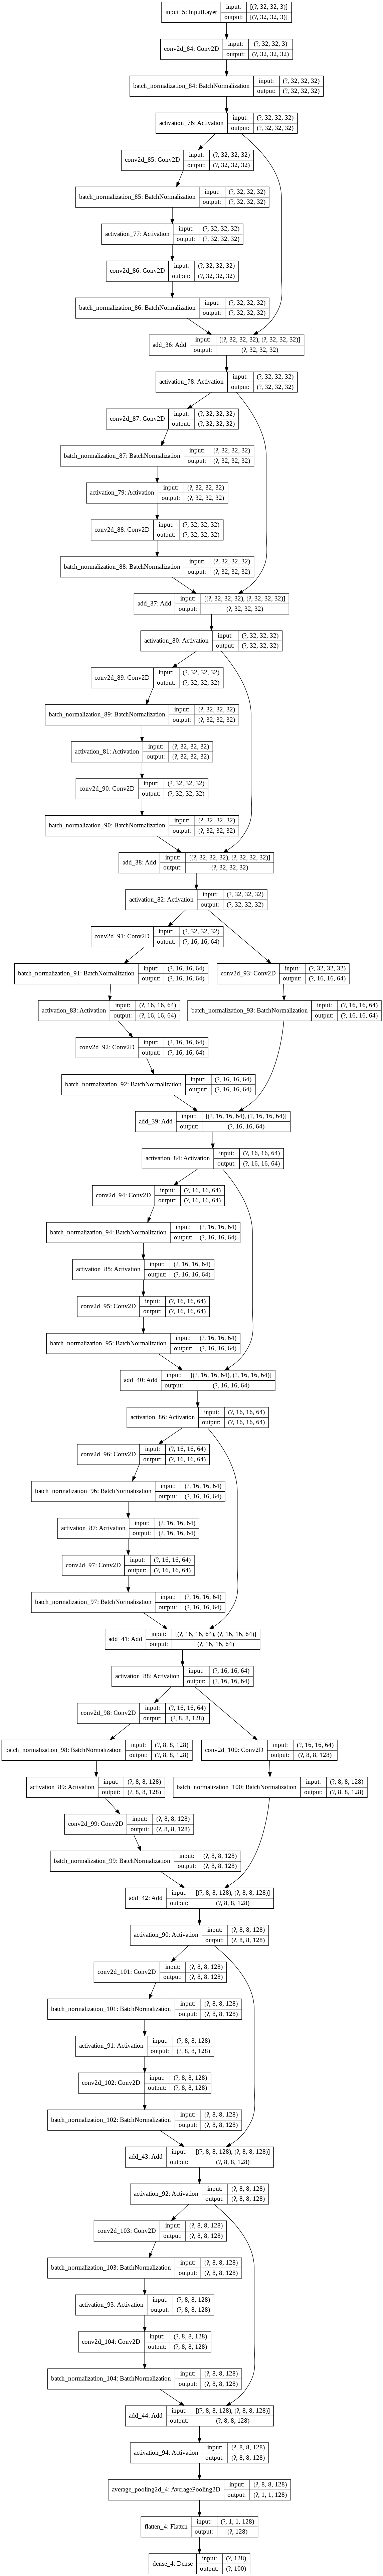

In [ ]:
model = create_model()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Learning rate 0.035 gave best results with decay 1e-5, accuracy dropped when lr/decay was increased
sgd = optimizers.SGD(lr=0.035, decay=1e-5,momentum=0.8)
adam = optimizers.Adam(lr=0.0006, decay = 1e-3,clipvalue=0.5) #use epoch around 180
model.compile(loss='categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0.0001,patience=6,mode='max')
checkpoint_path = "ResNet18_ADAM_BatchNormalization"
best_model = ModelCheckpoint(filepath = checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max')
# batch size to 128 for best accuracy, it decreases if batch size is increased
history = model.fit(x_train, y_train,
                    batch_size= 128,
                    epochs=150,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping,best_model],verbose=2)

Epoch 1/150
391/391 - 15s - loss: 4.8865 - accuracy: 0.1309 - val_loss: 5.4865 - val_accuracy: 0.0443
Epoch 2/150
391/391 - 14s - loss: 3.7371 - accuracy: 0.2765 - val_loss: 3.7226 - val_accuracy: 0.2592
Epoch 3/150
391/391 - 14s - loss: 3.1496 - accuracy: 0.3715 - val_loss: 3.2306 - val_accuracy: 0.3379
Epoch 4/150
391/391 - 14s - loss: 2.7696 - accuracy: 0.4428 - val_loss: 3.0669 - val_accuracy: 0.3842
Epoch 5/150
391/391 - 14s - loss: 2.4830 - accuracy: 0.4996 - val_loss: 2.7834 - val_accuracy: 0.4267
Epoch 6/150
391/391 - 14s - loss: 2.2519 - accuracy: 0.5496 - val_loss: 2.8178 - val_accuracy: 0.4206
Epoch 7/150
391/391 - 14s - loss: 2.0608 - accuracy: 0.5935 - val_loss: 2.7932 - val_accuracy: 0.4233
Epoch 8/150
391/391 - 14s - loss: 1.8834 - accuracy: 0.6357 - val_loss: 2.5985 - val_accuracy: 0.4645
Epoch 9/150
391/391 - 14s - loss: 1.7215 - accuracy: 0.6763 - val_loss: 2.7162 - val_accuracy: 0.4466
Epoch 10/150
391/391 - 14s - loss: 1.5691 - accuracy: 0.7178 - val_loss: 2.5218 - 

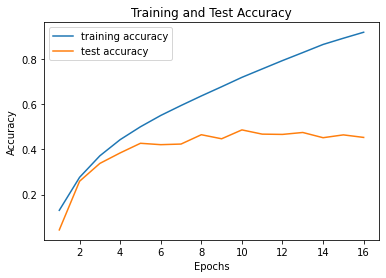

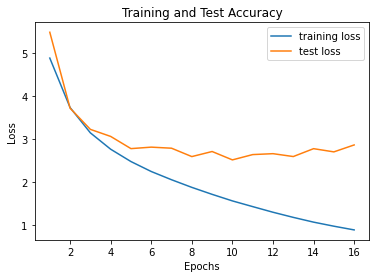

In [ ]:
#plot Accuracy vs epochs
train_metrics = history.history['accuracy']
val_metrics = history.history['val_accuracy']
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training accuracy", 'test accuracy'])
plt.show()
#plot Validaiton loss vs epochs
train_metrics = history.history['loss']
val_metrics = history.history['val_loss']
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.title('Training and Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training loss", 'test loss'])
plt.show()

In [ ]:
model = create_model()
# checkpoint_path = "../weights/ResNet18_ADAM_BatchNormalization"
checkpoint_path = "ResNet18_ADAM_BatchNormalization"
model.load_weights(checkpoint_path)
# loss,acc = model.evaluate(x_test,  y_test, verbose=2)
# print('Test Accuracy:', acc)
cm = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(-1))
print(cm)
precision = precision_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1), average='weighted')

accuracy= accuracy_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1))
recall= recall_score(y_test.argmax(axis=1), model.predict(x_test).argmax(-1), average='weighted')

print('precision:', precision)
print('accuracy:', accuracy)
print('recall:', recall)

[[54  1  0 ...  0  0  0]
 [ 0 43  0 ...  0  0  3]
 [ 0  1 37 ...  0  9  0]
 ...
 [ 0  0  0 ... 32  2  0]
 [ 0  1  2 ...  0 26  1]
 [ 0  0  0 ...  0  0 63]]
precision: 0.5184332951646267
accuracy: 0.4858
recall: 0.4858
